# CS 109B Project - Posters Classifiers
**Harvard University**<br>
**Spring 2017**<br>



<br>

**Group 26**


<br>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

# import pydotplus
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score as KFcv
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier as BaseLine
from sklearn.decomposition import PCA
from sklearn.utils import resample

import StringIO
import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


<br>
### Load Data:

<br>

In [3]:
# Reading data file for posters
# raw = pd.read_csv('Data4000.csv').iloc[:,1:]

raw = pd.read_csv('Data4000_2.csv')

# Display a sample
raw1.head(10)

,mR,mG,mB,stdR,stdG,stdB,D1,D2,D3,Action,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,id
0,138.006544,103.151856,89.324414,85.479174,81.446388,65.568723,0.132646,0.594158,0.266957,0,...,0,1,0,0,0,0,0,0,0,27597
1,38.438749,49.860981,54.109851,59.479920,61.367471,64.864368,0.085954,0.215642,0.036649,0,...,0,0,0,0,0,0,1,0,0,11478
2,219.592109,202.899499,173.125807,66.055096,82.186712,97.534423,0.293760,0.652414,0.379470,0,...,0,0,0,0,0,0,0,0,0,21340
3,122.911760,115.851421,80.549536,72.964230,72.473211,58.126026,0.029807,0.097680,0.046794,0,...,0,0,0,0,0,0,1,0,0,10108
4,165.836052,136.781236,128.247907,69.566960,94.515454,92.328557,0.085802,0.080205,0.004264,0,...,0,0,0,0,0,0,0,0,0,25887
5,72.358892,66.000839,57.401821,71.599428,70.797137,67.563953,0.012116,0.089889,0.069044,0,...,0,0,1,1,0,0,1,0,0,20285
6,123.312166,116.736247,114.743166,61.277977,58.213707,61.605004,0.131037,0.399847,0.129209,0,...,0,0,0,0,0,0,1,0,0,25634
7,137.280384,123.215549,103.472776,99.227489,74.794003,59.029507,0.219804,1.168127,0.861702,0,...,0,0,0,0,1,0,0,0,0,17009
8,88.562067,77.694171,74.958909,81.622705,74.794307,72.491142,0.280887,0.321527,0.016313,1,...,0,0,0,0,0,0,0,0,0,15801
9,182.401296,183.006480,185.003280,61.263635,68.682628,72.209176,0.070558,0.155153,0.021150,0,...,0,0,0,1,1,0,0,0,0,16633


In [23]:
# Initiate the labels array
labels = []

# Extract the labels data
labels_raw = raw1.columns[9:-1]

# Execute for each movie genre
for i in range(len(labels_raw)):
    
    # Append to the label array
    labels.append(str(labels_raw[i]))

# Define features dataframe    
X1df = raw1.iloc[:,:9]
X2df = raw2[['D1' , 'D2' , 'D3']]
X2df.columns = ['D1e' , 'D2e' , 'D3e']

Xdf = pd.concat([X1df , X2df] , 1)

In [24]:
Xdf.head()


,mR,mG,mB,stdR,stdG,stdB,D1,D2,D3,D1e,D2e,D3e
0,138.006544,103.151856,89.324414,85.479174,81.446388,65.568723,0.132646,0.594158,0.266957,33633.168747,58858.089087,34795.920609
1,38.438749,49.860981,54.109851,59.479920,61.367471,64.864368,0.085954,0.215642,0.036649,16898.795845,26961.960926,10989.407809
2,219.592109,202.899499,173.125807,66.055096,82.186712,97.534423,0.293760,0.652414,0.379470,36509.103714,64276.639948,50754.706333
3,122.911760,115.851421,80.549536,72.964230,72.473211,58.126026,0.029807,0.097680,0.046794,11704.512420,32653.176201,26312.860297
4,165.836052,136.781236,128.247907,69.566960,94.515454,92.328557,0.085802,0.080205,0.004264,30733.656811,32831.441836,7438.823563


In [18]:
# Specify a Single Label and features:
# ------------------------------------
def data_split(label):

    # Select label
    Y = raw1[label].values

    # transform Features to array
    X = Xdf.values

    # Extract the in/out class observations
    X_yes = X[Y == 1]
    X_no  = X[Y == 0] 

    # Extract the in/out class labels
    Y_yes = Y[Y == 1]
    Y_no  = Y[Y == 0]


    # Split into training and test sets:
    # ----------------------------------

    # Calculate the in class length
    L_yes = len(Y_yes)

    # Consider 70% for training
    Len_train = int(round(0.7 * L_yes))

    # Coordinates for test and train
    st_train = 0
    end_train = Len_train
    st_test = Len_train
    end_test = L_yes

    # Make the split for Features - Training
    X_train_yes = X_yes[st_train:end_train, :]
    X_train_no  = X_no[st_train:end_train , :]

    # Make the split for Features -Test
    X_test_yes  = X_yes[st_test:end_test,:]
    X_test_no   = X_no[st_test:end_test, :]

    # Make the split for Labels - Training
    Y_train_yes = Y_yes[st_train:end_train]
    Y_train_no  = Y_no[st_train:end_train]

    # Make the split for Labels -Test
    Y_test_yes  = Y_yes[st_test:end_test]
    Y_test_no   = Y_no[st_test:end_test]

    # Concatenate Train and test
    x_train = np.concatenate((X_train_yes , X_train_no) , 0)
    x_test  = np.concatenate((X_test_yes  , X_test_no ) , 0)

    y_train = np.concatenate((Y_train_yes , Y_train_no) , 0)
    y_test  = np.concatenate((Y_test_yes  , Y_test_no ) , 0)
    
    return x_train , y_train , x_test , y_test

In [19]:
labelsum = []
for i in range(len(labels)):
    
    labelsum.append(np.sum(raw1[labels[i]].values))
    
LabelSumdf = pd.DataFrame(np.array(labelsum) , columns = ['Sum'] , index = labels)  

### Fitting Models:

<br>

In [20]:
# Try different models without any tuning to have a preliminary orientation:
# criteria will be faulse positive score and true positive score
# Based on their importance for the classification
# ---------------------------------------------------------------------------------------

def multi_model(x_train , y_train , x_test , y_test):
    
    # logistic regression
    logreg = LogReg()
    logreg.fit(x_train , y_train)
    acc1 = logreg.score(x_test[y_test == 1] , y_test[y_test == 1])


    # LDA
    lda = LDA(solver = 'lsqr' , shrinkage = 'auto')
    lda.fit(x_train ,y_train)
    acc3 = lda.score(x_test[y_test == 1] , y_test[y_test == 1])

    # QDA
    qda = QDA()
    qda.fit(x_train ,y_train)
    acc4 = qda.score(x_test[y_test == 1] , y_test [y_test == 1])

    # Decision Tree
    dt = DecisionTree(max_depth = 10, class_weight = 'balanced')
    dt.fit(x_train ,y_train)
    acc5 = dt.score(x_test[y_test == 1] , y_test[y_test == 1] )


    # SVC
    svc1 = RandomForest(oob_score = True)
    svc1.fit(x_train, y_train)
    acc6 = svc1.score(x_test[y_test == 1], y_test[y_test == 1])

    return [acc1 , acc3 , acc4 , acc5 , acc6]

In [21]:
Acc = []

for i in range(len(labels)):
    
    x_train, y_train, x_test, y_test = data_split(labels[i])
    
    acc = multi_model(x_train , y_train , x_test, y_test)
    
    Acc.append(acc)
    
Acc_array = np.array(Acc).T
Acc_array.shape
Acc_df = pd.DataFrame(Acc_array , columns = labels , index = ['Logreg' , 'LDA' , 'QDA' , 
                                                              'Decision Tree' , 'Random Forest'])
Acc_df

C:\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Logreg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0000,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
LDA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0000,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
QDA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.985915,0.9375,1.0,1.0,1.0,1.000000,0.990476,1.0,1.0,1.0,1.0
Decision Tree,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0000,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
Random Forest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.990909,1.000000,1.0000,1.0,1.0,1.0,0.994413,1.000000,1.0,1.0,1.0,1.0


In [22]:
LabelSumdf

,Sum
Action,796
Adventure,390
Animation,239
Comedy,1420
Crime,466
Documentary,221
Drama,1724
Family,368
Fantasy,237
History,108



<br>
Models to be considered are Decision Tree Since its performance is close to the target

<br>

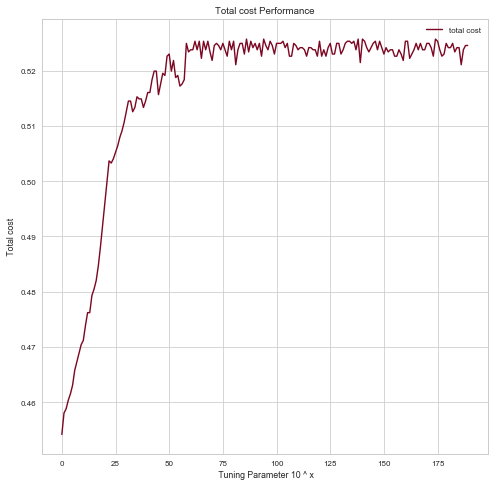

In [164]:
# Tuning the Selected model:
# -------------------------

x_train , y_train , x_test , y_test = data_split('Drama')

# parameter array 
c_array = np.arange(-9, 10, 0.1)
# c_array = np.arange(-9, 0 , 0.1)

# score array
score_arr = np.zeros(c_array.shape)

# K Folds
kf = KFold(n_splits = 5)

# Itterrate over the parameter range
for i , c in enumerate (c_array):
    
    # modlist = [LogReg( C = 10 ** c) , LDA(solver = 'lsqr' , shrinkage = 100**c) , QDA(reg_param = 10**c)]
    
    # mod = LDA(solver = 'lsqr' , shrinkage = 10 ** c)
    
    # mod  = DecisionTree(max_depth = c)
    
    # mod = QDA(reg_param = 10 ** c)
    
    mod = modlist[0]
    
    set_score = []
    
    for train_index , test_index in kf.split(x_train):

        xtr , xts = x_train[train_index] , x_train[test_index]
        ytr , yts = y_train[train_index] , y_train[test_index]
        model = mod.fit(xtr,ytr)
        ypr = model.predict(xtr)
        set_score.append(model.score(x_test[y_test == 1] , y_test[y_test == 1]))
        score_set_array = np.array(set_score)
        
    score_arr[i] = np.average(score_set_array)


best_c = c_array[np.argmax(score_arr)]

# visualize
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(111)
ax.plot(score_arr, label = 'total cost')
ax.set_title('Total cost Performance')
ax.set_xlabel(' Tuning Parameter 10 ^ x')
ax.set_ylabel(' Total cost')
ax.legend()
plt.show()

In [ ]:
print '\n Best parameter = ' , best_c

In [ ]:
# Build classifier
# ----------------

mod1 = LogReg (C = 10 ** best_c)
# mod1 = DecisionTree(max_depth = best_c)
# mod1 = LDA(solver = 'lsqr' , shrinkage = 10 ** best_c)
# mod1 = QDA(reg_param = 10**best_c)
model_1 = mod1.fit(x_train, y_train)


# Clasifier performance
# Observed Data = Train Data
# Future Data = Test data
# ---------------------------

print '\nModel Results:'
print '---------------'
print 'expected accuracy on training data  : ' , model_1.score(x_train , y_train)
print 'expected accuracy on test data :' , model_1.score(x_test[y_test == 1] , y_test[y_test == 1])


### END